## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
# Let's create the function to create adjusted R-Squared
def adj_r2(x, y):
    r2 = regression.score(x, y)
    n = x.shape[0]
    p = x.shape[1]
    adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
    return adjusted_r2

## Load the dataset

In [3]:
df = pd.read_csv('Admission_Prediction.csv')
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337.0,118.0,4.0,4.5,4.5,9.65,1,0.92
1,2,324.0,107.0,4.0,4.0,4.5,8.87,1,0.76
2,3,NaN,104.0,3.0,3.0,3.5,8.00,1,0.72
3,4,322.0,110.0,3.0,3.5,2.5,8.67,1,0.80
4,5,314.0,103.0,2.0,2.0,3.0,8.21,0,0.65


In [4]:
df.describe(include = 'all')

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,485.000000,490.000000,485.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.558763,107.187755,3.121649,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.274704,6.112899,1.146160,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


## Checking the missing values

In [5]:
df.isna().sum()

Serial No.            0
GRE Score            15
TOEFL Score          10
University Rating    15
SOP                   0
LOR                   0
CGPA                  0
Research              0
Chance of Admit       0
dtype: int64

## Handling the missing value

In [6]:
# Categorical column
df['University Rating'] = df['University Rating'].fillna(df['University Rating'].mode()[0])

# Numerical value
df['GRE Score'] = df['GRE Score'].fillna(df['GRE Score'].mean())
df['TOEFL Score'] = df['TOEFL Score'].fillna(df['TOEFL Score'].mean())

In [7]:
df.isna().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

- Now the data looks good and there are no null/missing values.
- Also, the first column is Serial numbers, so we don not need that column. Let's drop that column.

In [8]:
df = df.drop(columns = ['Serial No.'])
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337.000000,118.0,4.0,4.5,4.5,9.65,1,0.92
1,324.000000,107.0,4.0,4.0,4.5,8.87,1,0.76
2,316.558763,104.0,3.0,3.0,3.5,8.00,1,0.72
3,322.000000,110.0,3.0,3.5,2.5,8.67,1,0.80
4,314.000000,103.0,2.0,2.0,3.0,8.21,0,0.65


## Data Visualization

- Let's visualize the data and analyze the relationship between independent and dependent variables:

### Check the distribution of the data for every column

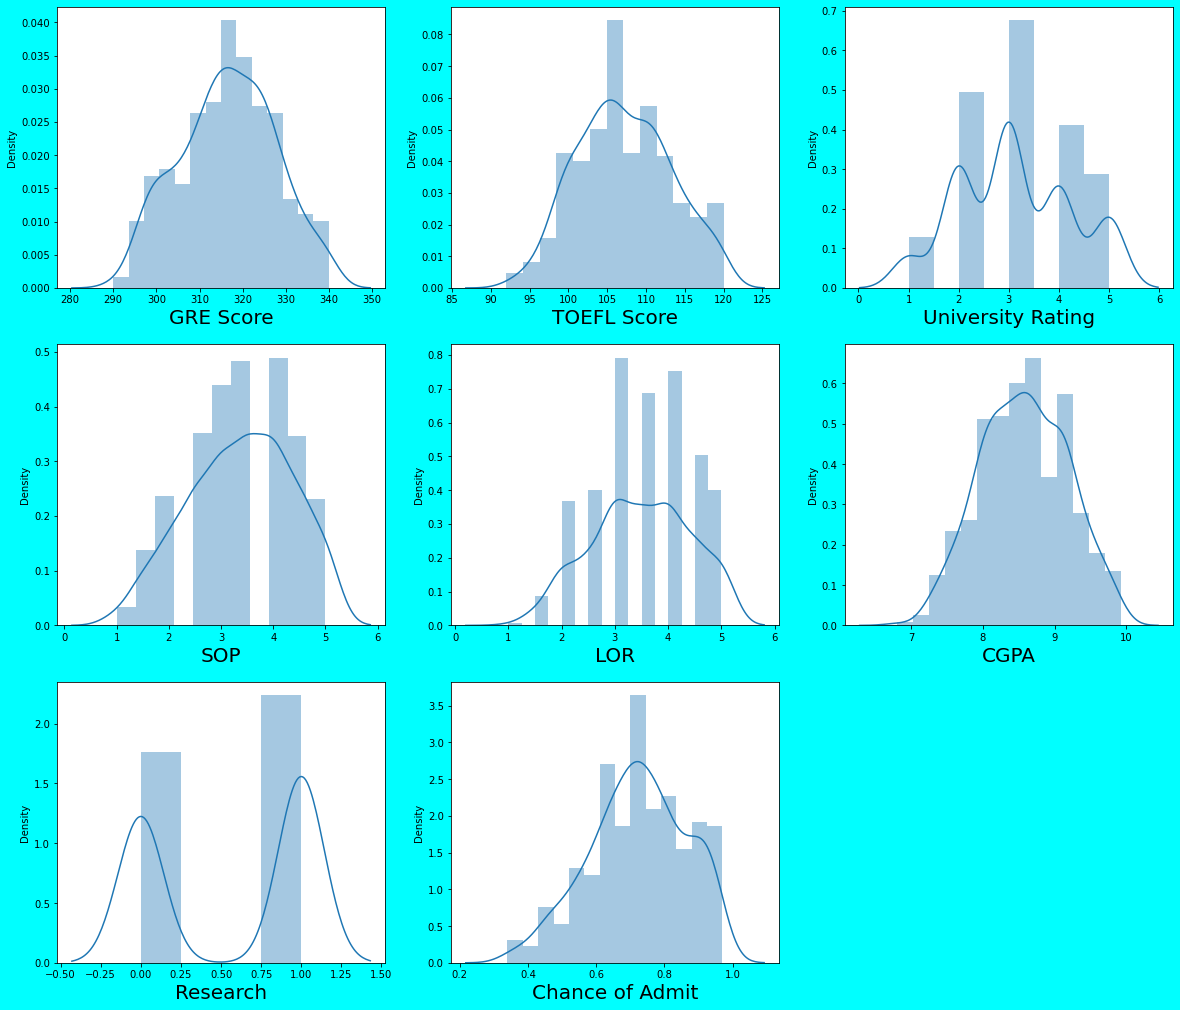

In [9]:
plt.figure(figsize = (20, 30), facecolor = 'cyan')
plt_no = 1
for column in df:
    if plt_no <= 15:
        ax = plt.subplot(5, 3, plt_no)
        sns.distplot(df[column])
        plt.xlabel(column, fontsize = 20)
    plt_no += 1
#plt.tight_layout()
plt.show()

- Data distribution looks decent enough and there doesn't seem to be any skewness.

### Relationship between the independent  variables and dependent variable

In [10]:
y = df['Chance of Admit']
X = df.iloc[:, :-1]

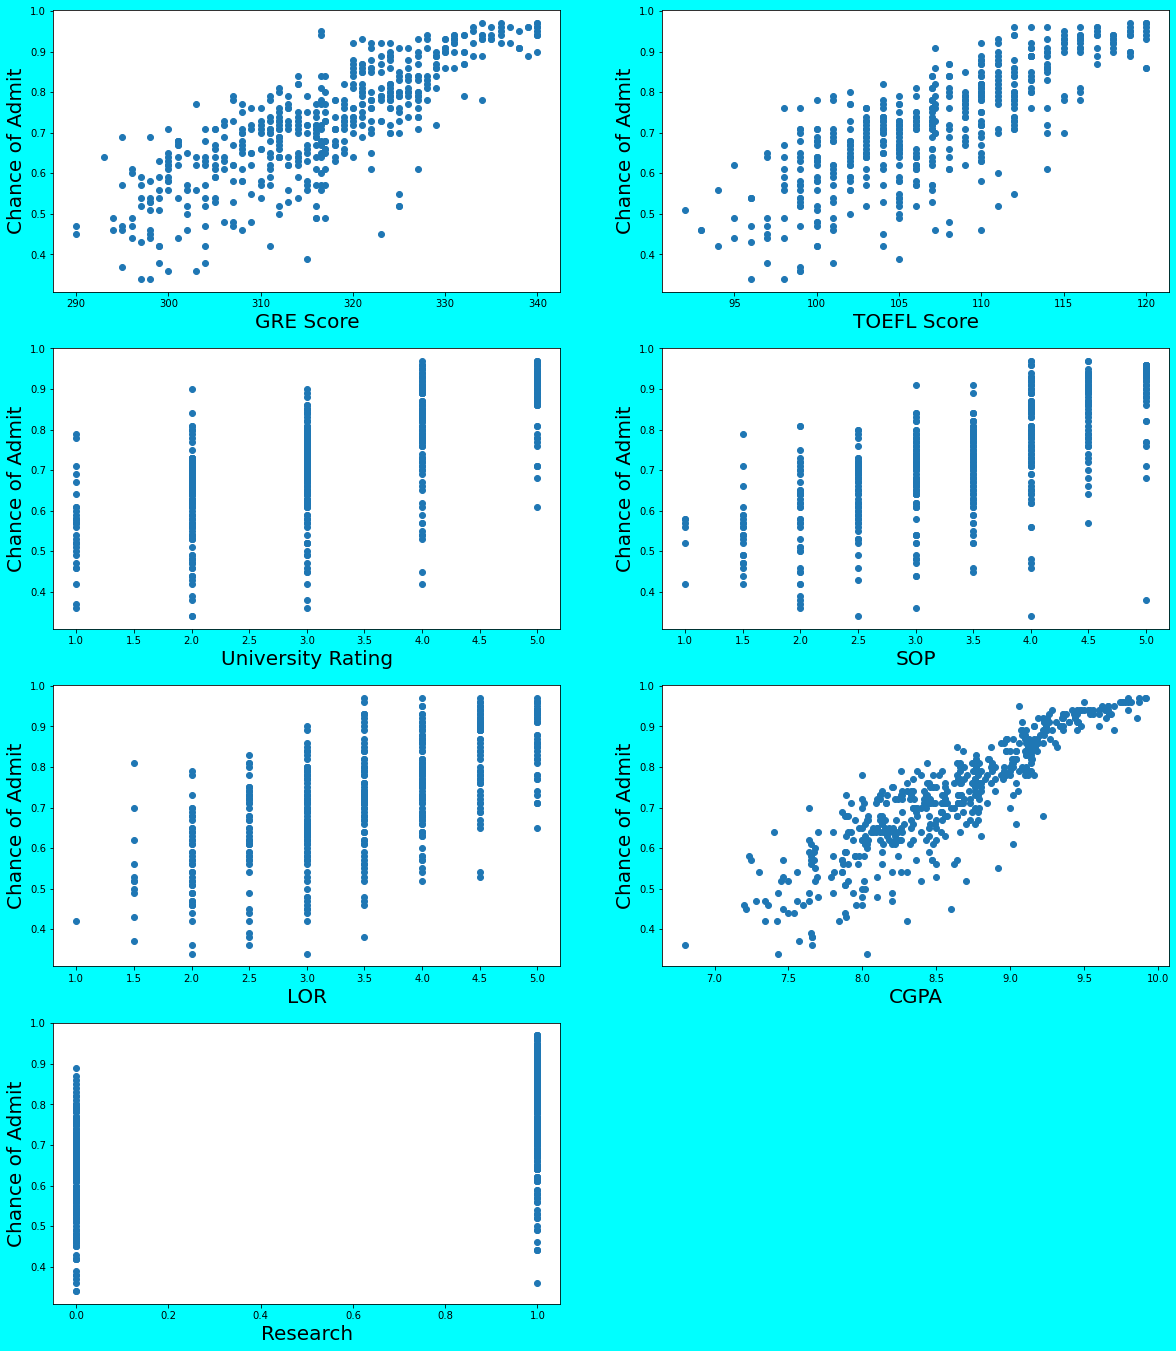

In [11]:
plt.figure(figsize = (20, 30), facecolor = 'cyan')
plt_no = 1
for column in X:
    if plt_no <= 10:
        ax = plt.subplot(5, 2, plt_no)
        plt.scatter(X[column], y)
        plt.xlabel(column, fontsize = 20)
        plt.ylabel('Chance of Admit', fontsize = 20)
    plt_no += 1
plt.show()

- The relationship between the dependent and independent variables looks fairly linear. 
- Thus, linearity assumption is satisfied.

### Check Multicollinearity

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = X_scaled

# we create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific 
# (not model specific)
# we do not include categorical values for mulitcollinearity as they do not provide much information as 
# numerical ones do
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = X.columns

In [14]:
vif

,VIF,Features
0,4.152735,GRE Score
1,3.793345,TOEFL Score
2,2.517272,University Rating
3,2.776393,SOP
4,2.037449,LOR
5,4.654369,CGPA
6,1.459411,Research


- Here we have the correlation values for all the features.
- A VIF value > 5 means a very severe multicollinearity. We don't have any VIF greater than 5.
- There is no multicollinearity among the independent variables.

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state = 28)

## Perform Regression

In [16]:
regression = LinearRegression()

In [17]:
regression.fit(x_train, y_train)

LinearRegression()

In [18]:
# saving the model to the local file system
filename = 'finalized_model.pickle'
pickle.dump(regression, open(filename, 'wb'))

In [19]:
regression.score(x_train, y_train)

0.8217843324405705

In [20]:
adj_r2(x_train, y_train)

0.8183851235225432

- Our r2 score is 82.17 % and adj r2 is 81.83 % for our training.

Let's check how well model fits the test data

In [21]:
regression.score(x_test, y_test)

0.8078278020390542

In [22]:
adj_r2(x_test, y_test)

0.7963303201097669

So it looks like our model r2 score is less on the test data.

Let's see if our model is overfitting our training data.

## Regularization Techniques


### Lasso Regularization
- LassoCV will return best alpha and coefficients after performing 10 cross validations


In [23]:
lasso_cv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lasso_cv.fit(x_train, y_train)

LassoCV(cv=10, max_iter=100000, normalize=True)

In [24]:
# best alpha parameter
alpha = lasso_cv.alpha_
alpha

6.623704018254393e-06

In [25]:
#now that we have best parameter, let's use Lasso regression and see how well our data has fitted before
lasso_reg = Lasso(alpha)
lasso_reg.fit(x_train, y_train)

Lasso(alpha=6.623704018254393e-06)

In [26]:
lasso_reg.score(x_test, y_test)

0.8078345015544183

- Our r2_score for test data (80.78 %) comes same as before using regularization. 
- So, it is fair to say our OLS model did not overfit the data.

### Ridge Regularization
- RidgeCV will return best alpha and coefficients after performing 10 cross validations. 
- We will pass an array of random numbers for ridgeCV to select best alpha from them

In [29]:
alphas = np.random.uniform(low = 0, high = 10, size = (50, ))
ridge_cv = RidgeCV(alphas = alphas, cv = 10, normalize = True)
ridge_cv.fit(x_train, y_train)

RidgeCV(alphas=array([6.0471701 , 4.01275783, 8.56471211, 8.87216833, 5.64689016,
       8.79355195, 1.39676778, 3.09359046, 8.79663716, 4.70966657,
       9.68437663, 6.81471389, 4.29021652, 6.62791805, 9.03051963,
       1.86009211, 6.04556545, 6.18894608, 8.78239537, 1.97189446,
       6.96235745, 5.23192875, 3.64070225, 9.03930387, 2.80046395,
       1.66263042, 3.18178824, 9.26080576, 7.66730417, 8.45514776,
       0.18508753, 6.88339035, 7.03270065, 4.48221194, 1.36851895,
       4.09148173, 6.46401721, 4.28646216, 4.3802782 , 7.26341565,
       2.47230593, 6.83191931, 7.83320002, 6.04484818, 7.32518956,
       4.27422211, 3.72715462, 6.54872518, 2.03624181, 7.94454877]),
        cv=10, normalize=True)

In [30]:
ridge_cv.alpha_

0.18508752949790708

In [31]:
ridge_reg = Ridge(alpha = ridge_cv.alpha_)
ridge_reg.fit(x_train, y_train)

Ridge(alpha=0.18508752949790708)

In [32]:
ridge_reg.score(x_test, y_test)

0.8078862662819232

- We got the same r2 square using Ridge regression as well. 
- So, it's safe to say there is no overfitting.

### ElasticNet

In [33]:
elastic_cv = ElasticNetCV(alphas = None, cv = 10)
elastic_cv.fit(x_train, y_train)

ElasticNetCV(cv=10)

In [34]:
elastic_cv.alpha_

0.0002598674954351098

In [36]:
# l1_ratio gives how close the model is to L1 regularization, below value indicates we are giving equal
# preference to L1 and L2
elastic_cv.l1_ratio

0.5

In [38]:
elasticnet_reg = ElasticNet(alpha = elastic_cv.alpha_, l1_ratio = elastic_cv.l1_ratio)
elasticnet_reg.fit(x_train, y_train)

ElasticNet(alpha=0.0002598674954351098)

In [39]:
elasticnet_reg.score(x_test, y_test)

0.8079841679973137